In [163]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2

In [164]:
# Define the directory and base file names for images and JSON files
image_directory = '/home/rijul/env/bin/mask/dataset/main/farms/farms'
json_directory = '/home/rijul/env/bin/mask/dataset/main/annotations/annotation_farms'
extension = '.png'

# Initialize empty lists to store images and masks
images = []
masks = []

# Loop through the range of image numbers
for i in range(1, 2):
    # Generate the image file path
    image_path = f'{image_directory}{i}{extension}'

    # Read the image
    img = cv2.imread(image_path)

    # Check if the image was read successfully
    if img is not None:
        images.append(img)
    else:
        print(f"Error reading {image_path}")

    # Generate the JSON file path
    json_path = f'{json_directory}{i}.json'

    # Read the JSON annotation mask
    try:
        with open(json_path, 'r') as json_file:
            mask_data = json.load(json_file)
        masks.append(mask_data)
        
    except FileNotFoundError:
        print(f"Error reading {json_path}")

In [165]:
# Check if you have successfully read 1 images and masks
if len(images) == 1 and len(masks) == 1:
    print("Successfully read 1 images and masks.")
else:
    print(f"Read {len(images)} images and {len(masks)} masks. Check your file paths.")

Successfully read 1 images and masks.


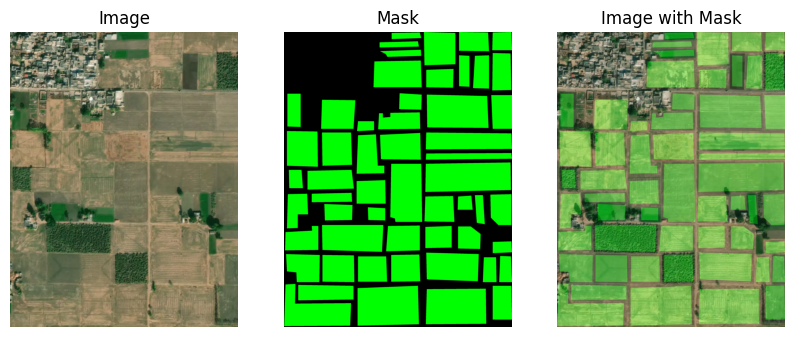

In [166]:
# Plot the 'farms1' image with its mask
index = 0  # Change this to the index of the image you want to plot (e.g., 0 for 'farms1')
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
plt.title('Image')
plt.axis('off')

# Create a mask image from the JSON data (you may need to adapt this part based on your JSON structure)
mask_data = masks[index]
mask = np.zeros_like(images[index], dtype=np.uint8)
for i in range(len(mask_data['Satellite Streets-1694147904194.png']['regions'])):
    polygon = np.array(mask_data['Satellite Streets-1694147904194.png']['regions'][str(i)]['shape_attributes']['all_points_x'], dtype=np.int32), np.array(mask_data['Satellite Streets-1694147904194.png']['regions'][str(i)]['shape_attributes']['all_points_y'], dtype=np.int32)
    polygon = np.transpose(polygon)
    cv2.fillPoly(mask, [polygon], (0, 255, 0))  # Green color for the mask

plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

# Overlay the mask on the image
masked_image = cv2.addWeighted(images[index], 0.9, mask, 0.3, 0)

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title('Image with Mask')
plt.axis('off')

plt.show()

In [167]:
import random

# Function to bisect the image and mask into 256x256 segments
def bisect_image_and_mask(image, mask):
    segments = []
    mask_segments = []
    height, width, _ = image.shape
    segment_size = 256

    for y in range(0, height, segment_size):
        for x in range(0, width, segment_size):
            segment = image[y:y+segment_size, x:x+segment_size]
            mask_segment = mask[y:y+segment_size, x:x+segment_size]

            if segment.shape[:2] == (segment_size, segment_size):
                segments.append(segment)
                mask_segments.append(mask_segment)

    return segments, mask_segments

# Choose a random index
random_index = random.randint(0, len(images) - 1)

# Bisect the image and mask at the random index
bisected_images, bisected_masks = bisect_image_and_mask(images[random_index], mask)

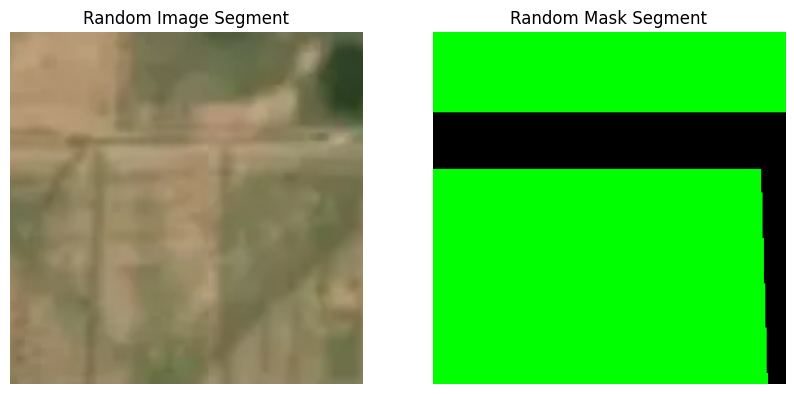

In [168]:
# Randomly select one segment
random_segment_index = random.randint(0, len(bisected_images) - 1)
random_segment = bisected_images[random_segment_index]
random_mask_segment = bisected_masks[random_segment_index]

# Plot the randomly selected segment and its mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(random_segment, cv2.COLOR_BGR2RGB))
plt.title('Random Image Segment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(random_mask_segment, cmap='gray')
plt.title('Random Mask Segment')
plt.axis('off')

plt.show()

In [169]:
len(bisected_images)

108

In [170]:
len(bisected_masks)

108

In [171]:
import random
import os
import shutil
import json

# Define the dataset directories
train_dir = './dataset/train'
val_dir = './dataset/val'

# Remove existing data in the directories
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

# Create the directories
os.makedirs(train_dir)
os.makedirs(val_dir)

# Define the split ratio (70% for training, 30% for validation)
split_ratio = 0.7

# Calculate the number of images for each split
num_total_segments = len(bisected_images)
num_train_segments = int(num_total_segments * split_ratio)
num_val_segments = num_total_segments - num_train_segments

# Create a list of indices for shuffling
indices = list(range(num_total_segments))
random.shuffle(indices)

# Iterate through the shuffled indices and save segments
for i, idx in enumerate(indices):
    segment_image = bisected_images[idx]
    segment_mask = bisected_masks[idx]

    if i < num_train_segments:
        # Save to the training directory
        train_image_path = os.path.join(train_dir, f"image_{i}.png")
        cv2.imwrite(train_image_path, segment_image)

        train_annotation_path = os.path.join(train_dir, f"annotation_{i}.json")
        annotation_data = {
            'image_id': f'image_{i}.png',
            'mask_data': segment_mask.tolist()  # Convert the mask to a nested list for JSON
        }
        with open(train_annotation_path, 'w') as json_file:
            json.dump(annotation_data, json_file)
    else:
        # Save to the validation directory
        val_image_path = os.path.join(val_dir, f"image_{i - num_train_segments}.png")
        cv2.imwrite(val_image_path, segment_image)

        val_annotation_path = os.path.join(val_dir, f"annotation_{i - num_train_segments}.json")
        annotation_data = {
            'image_id': f'image_{i - num_train_segments}.png',
            'mask_data': segment_mask.tolist()  # Convert the mask to a nested list for JSON
        }
        with open(val_annotation_path, 'w') as json_file:
            json.dump(annotation_data, json_file)

print("Data splitting and saving complete.")

Data splitting and saving complete.


In [172]:
import json

# Specify the path to the JSON file you want to read
json_file_path = './dataset/train/annotation_0.json'

# Read and load the JSON data
with open(json_file_path, 'r') as json_file:
    annotation_data = json.load(json_file)

#annotation_data

In [173]:
annotations = list(annotation_data.values())
annotations

['image_0.png',
 [[[0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 255, 0],
   [0, 2

In [174]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [175]:
# Creates a session with device placement logs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Device mapping: no known devices.


2023-09-12 14:26:11.456659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-12 14:26:11.457044: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [176]:
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

In [177]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [178]:
ROOT_DIR

'/home/rijul/env/bin/mask'

In [179]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"


    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    
    # Number of classes (including background)
    NUM_CLASSES = 1+1

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 80% confidence
    DETECTION_MIN_CONFIDENCE = 0.8

In [180]:
import os
import skimage
import numpy as np
import json
from mrcnn import utils

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
      
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "farm")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations from JSON file
        annotations_file = os.path.join(dataset_dir, "annotation_0.json")
        with open(annotations_file, "r") as f:
            annotations_data = json.load(f)

        # Process annotations
        for image_id, mask_data in annotations_data.items():
            # Construct the correct image file path
            image_filename = image_id
            image_path = os.path.join(dataset_dir, image_filename)

            # Check if the image file exists before attempting to load it
            if not os.path.exists(image_path):
                continue

            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            # Initialize lists for polygons and num_ids
            polygons = []
            num_ids = []

            for mask in mask_data:
                # Convert mask data into polygons
                mask = np.array(mask)
                rr, cc = skimage.draw.polygon(mask[:, 1], mask[:, 0])
                polygons.append({
                    "all_points_y": rr,
                    "all_points_x": cc
                })

                # Assign class ID (assuming "farm" is always class 1)
                num_ids.append(1)

            self.add_image(
                "object",  # for a single class just add the name here
                image_id=image_filename,  # use the file name as a unique image id
                path=image_path,
                width=width,
                height=height,
                polygons=polygons,
                num_ids=num_ids
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not an "object" dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [181]:
arr = np.array(mask)
np.unique(arr)

array([  0, 255], dtype=uint8)

In [182]:
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom("/home/rijul/env/bin/mask/dataset", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("/home/rijul/env/bin/mask/dataset", "val")
dataset_val.prepare()

In [183]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [20]:
import skimage
real_test_dir = '/home/rijul/env/bin/mask/dataset'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

NameError: name 'model' is not defined

In [161]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
      
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "farm")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations from JSON file
        annotations_file = os.path.join(dataset_dir, "annotation_0.json")
        with open(annotations_file, "r") as f:
            annotations_data = json.load(f)

        # Process annotations
        for image_id, masks in annotations_data.items():
            # Construct the correct image file path
            image_filename = image_id
            image_path = os.path.join(dataset_dir, image_filename)

            # Check if the image file exists before attempting to load it
            if not os.path.exists(image_path):
                continue

            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            # Initialize lists for polygons and num_ids
            polygons = []
            num_ids = []

            for mask in masks:
                # Convert mask data into polygons
                mask = np.array(mask)
                rr, cc = skimage.draw.polygon(mask[:, 1], mask[:, 0])
                polygons.append({
                    "all_points_y": rr,
                    "all_points_x": cc
                })

                # Assign class ID (assuming "farm" is always class 1)
                num_ids.append(1)

            self.add_image(
                "farm",  # for a single class just add the name here
                image_id=image_filename,  # use the file name as a unique image id
                path=image_path,
                width=width,
                height=height,
                polygons=polygons,
                num_ids=num_ids
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")


#model_path = model.find_last()
model_path = '/home/rijul/env/bin/mask/logs'


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)